# IV/FI Curve Analysis

Copyright (c) 2025 Open Brain Institute

Authors: Ilkan Kilic and Darshan Mandge

last modified: 08.2025

## Summary
This notebook demonstrates how to compute and plot the IV (current-voltage) and FI (frequency-current) curves for single cell model using BlueCelluLab. These analyses provide insights into the neuron’s electrical properties, such as its input resistance, firing threshold, and response to varying levels of stimulation. The notebook also explains how to set different injection and recording locations to study various neuron behaviors, like dendritic integration, backpropagation, and somatic excitability, through IV and FI curve analyses.

In [ ]:
from entitysdk import Client
from obi_auth import get_token
from pathlib import Path


from obi_notebook import get_projects
from obi_notebook import get_entities
from entitysdk.downloaders.memodel import download_memodel
from entitysdk.models import MEModel

token = get_token(environment="production", auth_mode="daf")
project_context = get_projects.get_projects(token)

In [ ]:
client = Client(environment="production", project_context=project_context, token_manager=token)

# Optional: Download using unique ID
entity_ID = "<MEMODEL-ID>"  # <<< FILL IN UNIQUE MEModel ID HERE

if entity_ID != "<MEMODEL-ID>":
    mmemodel_ids = [entity_ID]
else:
# Alternative: Select from a table of entities
    mmemodel_ids = []
    mmemodel_ids = get_entities.get_entities("memodel", token, mmemodel_ids,
                                            project_context=project_context,
                                            multi_select=False,
                                            default_scale="small")

In [42]:
memodel = client.get_entity(
    entity_type=MEModel,
    entity_id=mmemodel_ids[0],
)
emodel_path=Path(str(memodel.id))
downloaded_memodel = download_memodel(
    client, memodel=memodel, output_dir=emodel_path
)

Please update `venv_path` with path to your python virtual environment.
Next, you will need to compile the mechanisms located in the emodel folder:

In [ ]:
# if you don't have the venv path try the last comment
# try by replacing >> {venv_path}/bin/nrnivmodl << with >> nrnivmodl << in the commands below

venv_path="../../../../.venv/"

# compile mechanisms
!'{venv_path}bin/nrnivmodl' {emodel_path}/mechanisms

# Alternatively
# import os
# os.system(f"{venv_path}/bin/nrnivmodl {emodel_folder_path}/mechanisms")

In [44]:
from bluecellulab.analysis.analysis import compute_plot_iv_curve, compute_plot_fi_curve
from bluecellulab.cell import Cell
from bluecellulab.circuit.circuit_access import EmodelProperties
from bluecellulab.simulation.neuron_globals import NeuronGlobals

Let's retrieve the emodel data and assign path to files and mechanisms.

In [45]:
hoc_folder = emodel_path / "hoc"
morph_folder = emodel_path / "morphology"
mechanisms_folder = emodel_path / "mechanisms"

Choose a morphology file from the list below. The first file in the folder is selected by default if no choice is made.

In [ ]:
from pathlib import Path
import ipywidgets as widgets
from IPython.display import display

morph_folder = Path(morph_folder)
morph_files = sorted([f.name for f in morph_folder.glob("*") if f.is_file()])

dropdown = widgets.Dropdown(
    options=morph_files,
    value=morph_files[0] if morph_files else None,
    description='Morphology:',
    disabled=False,
)
display(dropdown)
morph_file = morph_folder / dropdown.value

Dropdown(description='Morphology:', options=('C060114A5.asc',), value='C060114A5.asc')

In [47]:
# Look for the only .hoc file in the folder.
# The filename is not fixed, but there must be exactly one file present.
files = [f for f in hoc_folder.iterdir() if f.is_file() and f.suffix == ".hoc"]

if len(files) == 0:
    raise FileNotFoundError(f"No file found in {hoc_folder}")
elif len(files) > 1:
    raise RuntimeError(f"Expected exactly one file in {hoc_folder}, but found {len(files)}: {[f.name for f in files]}")
else:
    hoc_file = files[0]

In [48]:
holding_current = memodel.calibration_result.holding_current
threshold_current = memodel.calibration_result.threshold_current
emodel_properties = EmodelProperties(
    threshold_current=threshold_current,
    holding_current=holding_current,
)

This cell sets global neuronal parameters for the NEURON simulation. The temperature affects ion channel kinetics, and the initial membrane potential should match the model’s resting voltage. Adjust these values based on your HOC model.

In [49]:
neuron_globals = NeuronGlobals.get_instance()
neuron_globals.temperature = 34.0
neuron_globals.v_init = -80.0

We can now create our cell using BlueCelluLab:

In [50]:
cell = Cell(hoc_file, morph_file, template_format="v6", emodel_properties=emodel_properties)

In [51]:
print(f"threshold current is {emodel_properties.threshold_current} nA.")
print(f"holding current is {emodel_properties.holding_current} nA.")

threshold current is 0.1624028733588378 nA.
holding current is -0.08750000000000001 nA.


Use the widgets below to choose the section and segment (0–1) where current will be injected and where voltage will be recorded.

In [52]:
from ipywidgets import Dropdown, FloatSlider, Layout, VBox
from IPython.display import display

class SectionSelector:
    def __init__(self, cell, inject_default="soma[0]", record_default="soma[0]", x_default=0.5):
        section_names = sorted(cell.sections.keys())

        self.injecting_section = Dropdown(
            options=section_names,
            value=inject_default if inject_default in section_names else section_names[0],
            description="Injecting:",
            layout=Layout(width="50%")
        )

        self.injecting_segment = FloatSlider(
            value=x_default,
            min=0.0,
            max=1.0,
            step=0.05,
            description="Inject@x:",
            readout_format=".2f",
            layout=Layout(width="50%")
        )

        self.recording_section = Dropdown(
            options=section_names,
            value=record_default if record_default in section_names else section_names[0],
            description="Recording:",
            layout=Layout(width="50%")
        )

        self.recording_segment = FloatSlider(
            value=x_default,
            min=0.0,
            max=1.0,
            step=0.05,
            description="Record@x:",
            readout_format=".2f",
            layout=Layout(width="50%")
        )

        display(VBox([
            self.injecting_section, self.injecting_segment,
            self.recording_section, self.recording_segment
        ]))

    def values(self):
        """Return section names and segment positions."""
        return (
            str(self.injecting_section.value).split(".")[-1],
            self.injecting_segment.value,
            str(self.recording_section.value).split(".")[-1],
            self.recording_segment.value
        )

In [53]:
selector = SectionSelector(cell)

To compute and plot the IV and FI curves, we can simply call the two functions below, passing only the cell as an argument. This runs the simulation with default parameters. 

In [54]:
injecting_sec_name, injecting_x, recording_sec_name, recording_x = selector.values()

--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


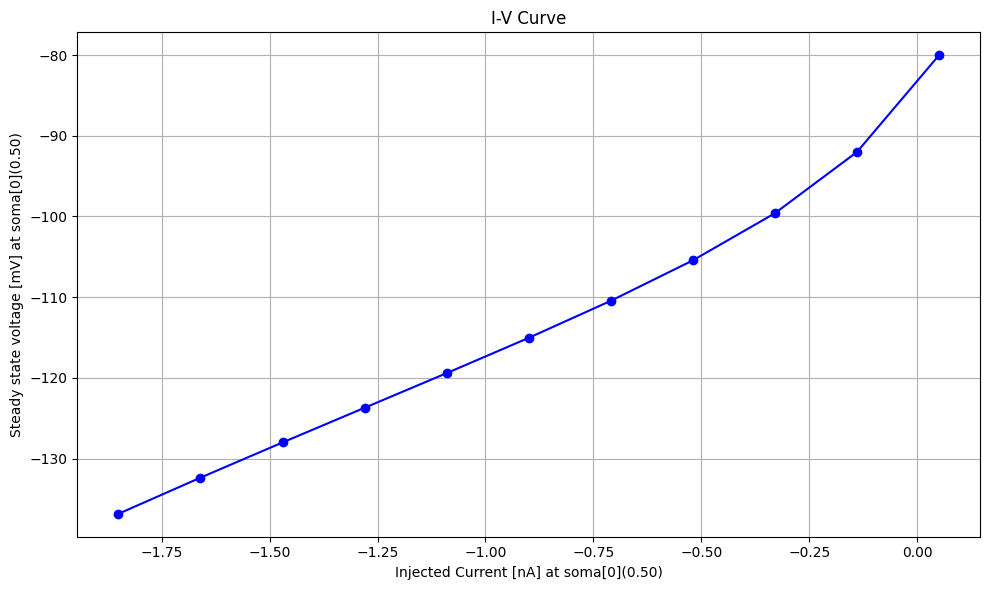

In [55]:
_, _ = compute_plot_iv_curve(cell, injecting_sec_name, injecting_x, recording_sec_name, recording_x)

--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


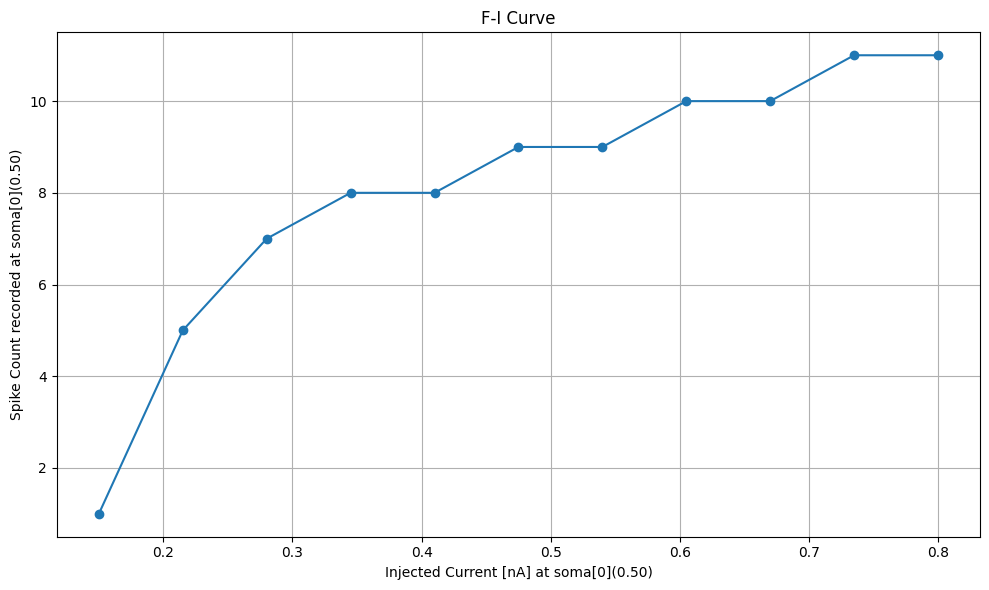

In [56]:
_, _ = compute_plot_fi_curve(cell, injecting_sec_name, injecting_x, recording_sec_name, recording_x)

## Use cases

The following cells present different use cases for computing and plotting IV and FI curves. Each case explores a unique injection and recording configuration to highlight key aspects of neuronal behavior, such as dendritic integration, backpropagation and axonal influence. These variations help demonstrate how different stimulation locations affect the cell's response.

In [57]:
# Default parameters for the following experiments
stim_start=100.0
duration=500.0
post_delay=100.0
threshold_voltage=-30
nb_bins = 11

In [58]:
def plot_iv_fi(injecting_section, injecting_segment, recording_section, recording_segment):
    _,_ = compute_plot_iv_curve(
        cell,
        injecting_section=injecting_section,
        injecting_segment=injecting_segment,
        recording_section=recording_section,
        recording_segment=recording_segment,
        stim_start=stim_start,
        duration=duration,
        post_delay=post_delay,
        threshold_voltage=threshold_voltage,
        nb_bins=nb_bins
    )
    _,_ = compute_plot_fi_curve(
        cell,
        injecting_section=injecting_section,
        injecting_segment=injecting_segment,
        recording_section=recording_section,
        recording_segment=recording_segment,
        stim_start=stim_start,
        duration=duration,
        post_delay=post_delay,
        nb_bins=nb_bins
    )

### Dendritic Integration and Attenuation

A typical configuration is to inject current into a distal dendrite and record the response at the soma. This reveals the effects of passive attenuation and active dendritic mechanisms on signal integration.

Use the widgets to experiment with different locations and observe how the site of input influences the somatic response.

In [59]:
selector = SectionSelector(cell)

--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


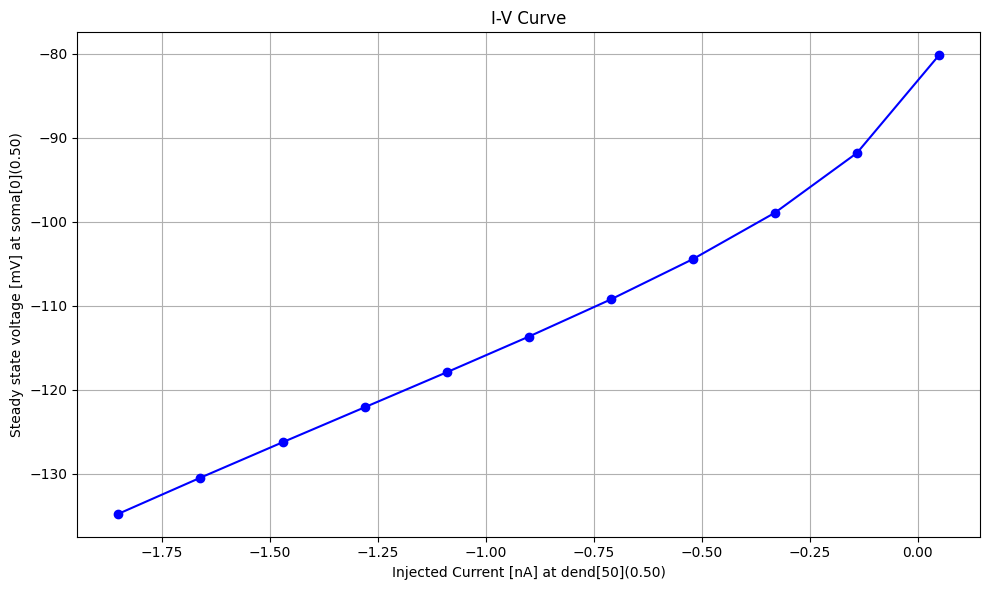

--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


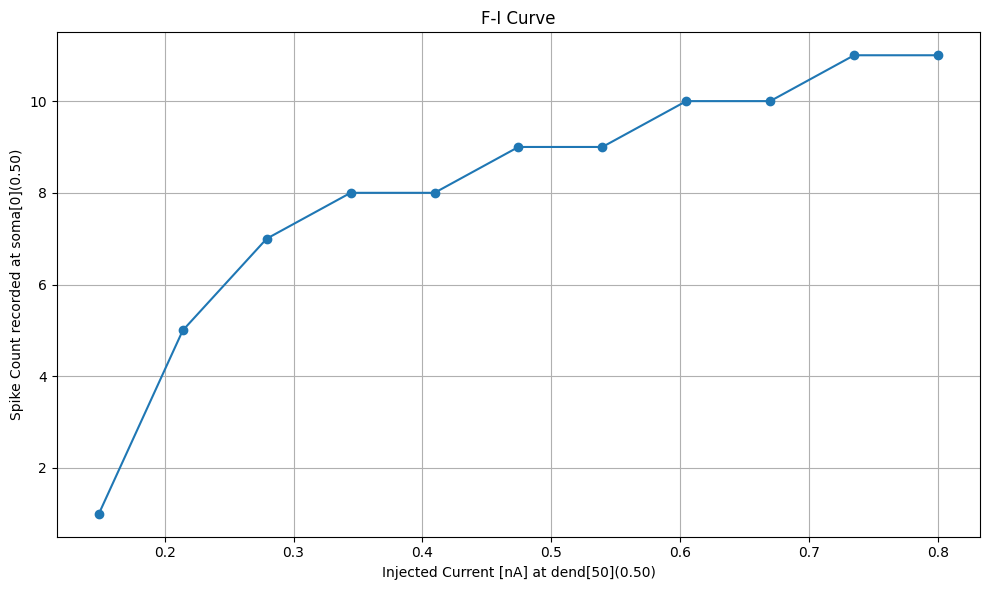

In [60]:
injecting_sec_name, injecting_x, recording_sec_name, recording_x = selector.values()
plot_iv_fi(injecting_sec_name, injecting_x, recording_sec_name, recording_x)

### Exploring Backpropagation from the Axon

Use the widgets below to explore how stimulation at the axon affects the soma.

A typical configuration is to inject current into an axonal section (e.g. near the initial segment) and record at the soma.  
This setup allows you to investigate whether axonal input can backpropagate to the soma and influence firing thresholds or excitability.

In [61]:
selector = SectionSelector(cell)

--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


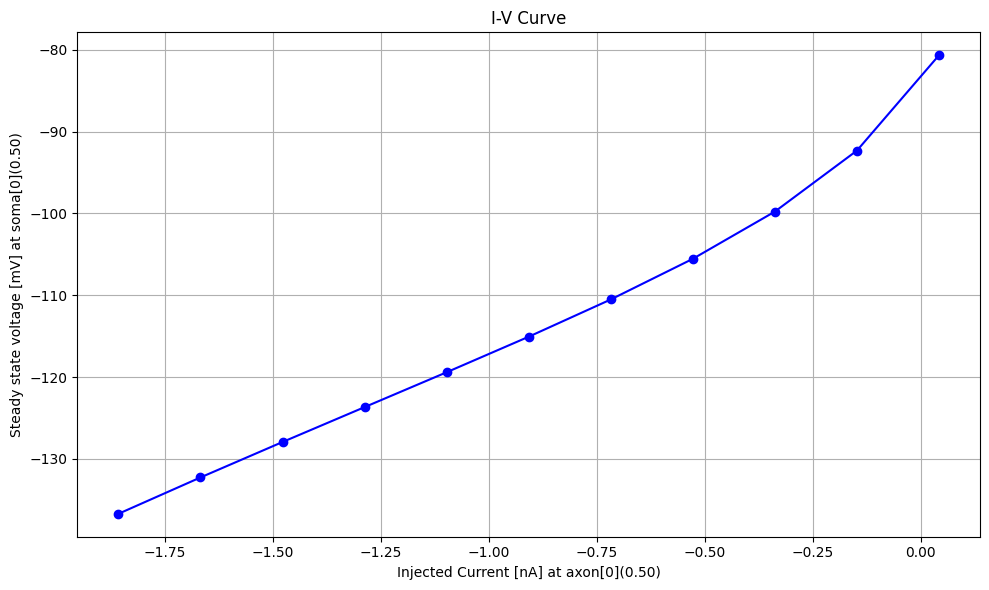

--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


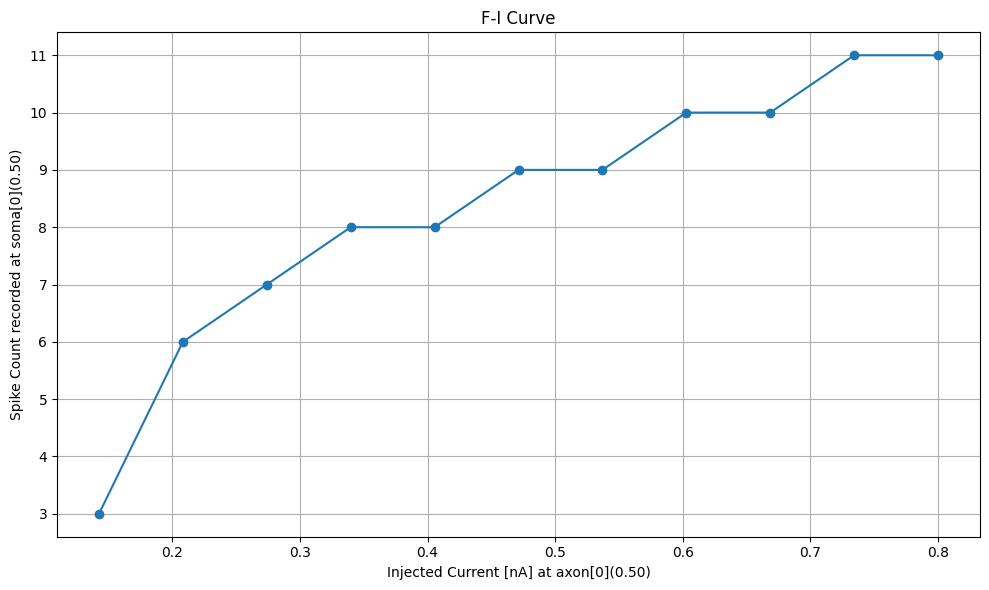

In [62]:
injecting_sec_name, injecting_x, recording_sec_name, recording_x = selector.values()
plot_iv_fi(injecting_sec_name, injecting_x, recording_sec_name, recording_x)

### Examining Local Dendritic Computations

Use the widgets below to inject current at one dendritic location and record at another.

By analyzing the IV or FI relationship between two dendritic sites, you can assess local integration, attenuation, and potential compartmentalisation.

Try comparing proximal and distal dendritic interactions or observe how signals fail or succeed in influencing remote dendritic branches.

In [63]:
selector = SectionSelector(cell)

--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


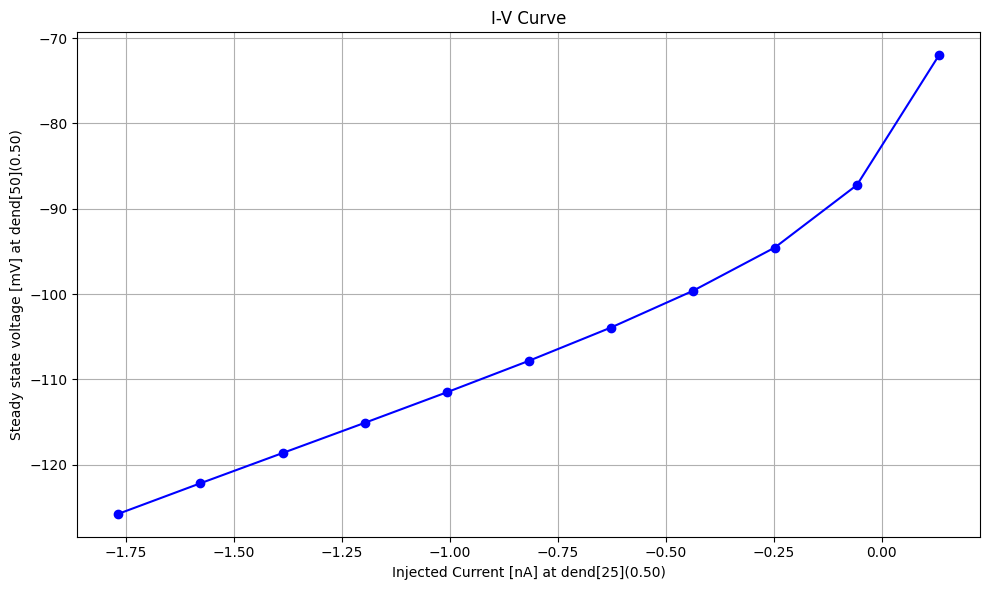

--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


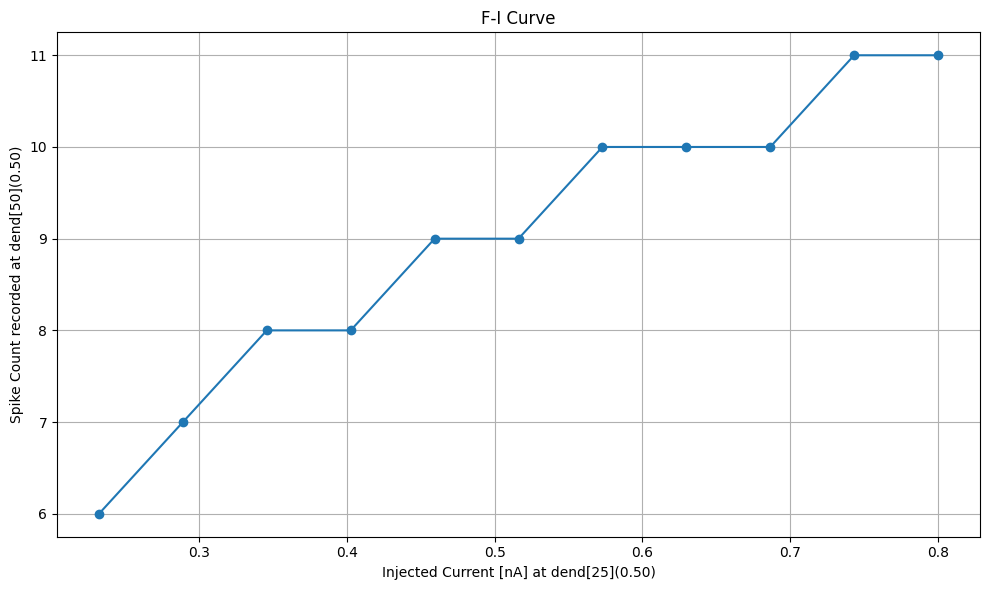

In [64]:
injecting_sec_name, injecting_x, recording_sec_name, recording_x = selector.values()
plot_iv_fi(injecting_sec_name, injecting_x, recording_sec_name, recording_x)

### Testing Whether Somatic Stimulation Reaches the Axon

This configuration tests whether somatic depolarization is sufficient to reach and activate the axon, a key step in action potential initiation.  

The IV curve will show how axonal voltage changes in response to increasing somatic input, while the FI curve can reveal the threshold and frequency of spike generation initiated from the soma.

Try adjusting the segment position within the axon to explore how excitability varies along its length.

In [65]:
selector = SectionSelector(cell)

--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


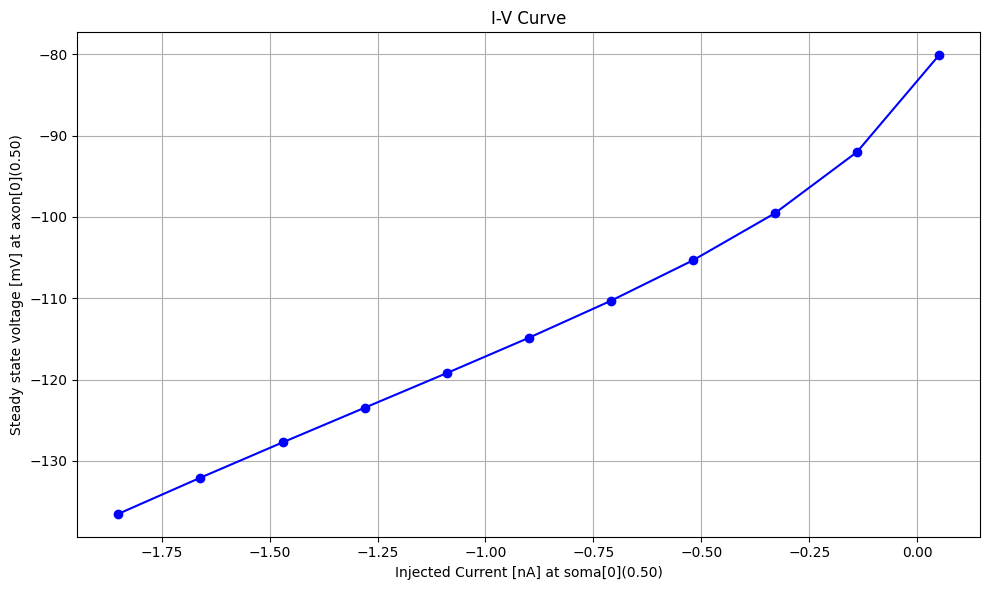

--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


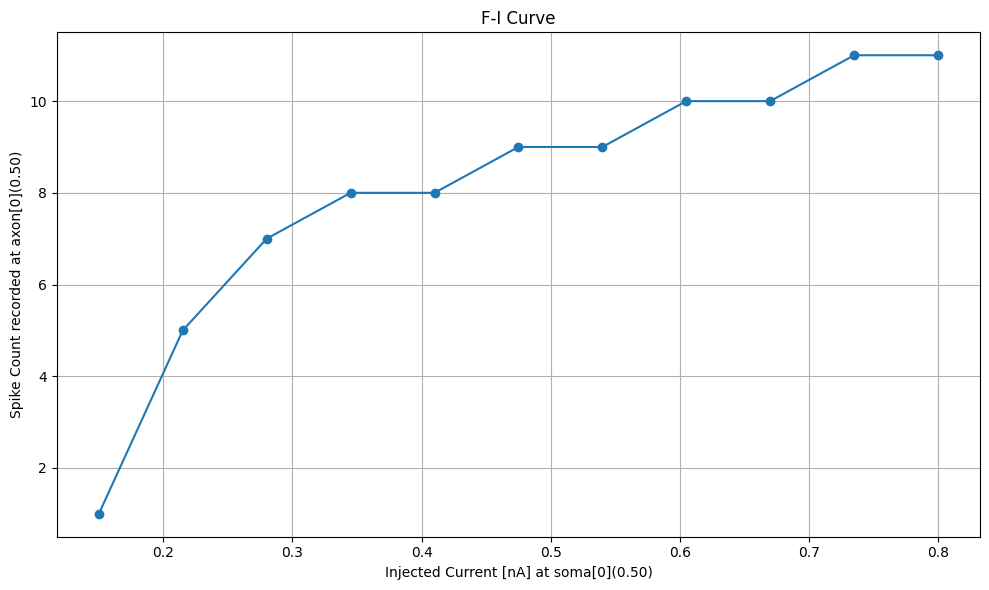

In [66]:
injecting_sec_name, injecting_x, recording_sec_name, recording_x = selector.values()
plot_iv_fi(injecting_sec_name, injecting_x, recording_sec_name, recording_x)